In [4]:
import pandas as pd 
import numpy as np 
import yfinance as yf
from lxml import html
import requests
import json

#trying to replace Sinclairs Long Strade quantile table to use on any stock 

In [11]:
stock = yf.Ticker('GOOGL')
def get_dispersion(yfinace_object, target_measure = 'Earnings',target_period = '0Q', number_of_analysts = True):
    """
    input: 
    yfinace_object -> yfinance.ticker.Ticker: yf.Ticker(GOOG)
    target_measure -> str: Revenue or Earnings
    target_period -> ['0Q', '+1Q', '0Y', '+1Y', '+5Y', '-5Y']: Estiamte period
    numbr_of_analysts -> Boolean: [True, False] Return amount of analyst estiamtes or not
    output: 
    dispersion -> Float: Dispersion of analyst measures
    analysts_count -> Int: Dispersion of analyst measures
    """
    analysis = yfinace_object.get_analysis().copy()
    hi_measure = analysis.loc[target_period][target_measure+" Estimate High"]
    avg_measure = analysis.loc[target_period][target_measure+" Estimate Avg"]
    lo_measure = analysis.loc[target_period][target_measure+" Estimate Low"]
    dispersion = round((hi_measure - lo_measure)/avg_measure,2)
    if number_of_analysts == True:
        analysts_count = analysis.loc[target_period][target_measure+" Estimate Number Of Analysts"]
        return dispersion, analysts_count
    else:
        return dispersion

get_dispersion(stock)

(0.07, 31.0)

In [33]:
stock = yf.Ticker('GOOGL')
def get_fundamental_straddle_stats(yfinace_object,dispersion_measure = 'Earnings', target_period = '0Q'):
    """
    Input:
        yfinance_object-> Yfinace_object: yf.Ticker(ticker_name)
        dispersion_measure -> str: ['Earnings','Revenue']
        target_period -> ['0Q', '+1Q', '0Y', '+1Y', '+5Y', '-5Y']: Estiamte period

    Output:
        target_measures -> Dictionary: Dictionary containing pre earnings measures of interest
                            that are indicative of profitable straddles
    """
    div_yield = yfinace_object.dividends[-1] if len(yfinace_object.dividends)>0 else 0
    dispersion, estimate_count = get_dispersion(yfinace_object,target_measure = dispersion_measure, target_period = target_period)
    price_earnings = yfinace_object.info['trailingPE']
    market_cap = yfinace_object.info['marketCap']
    target_measures = {
        'PE':price_earnings,
        'Market Cap':"{:,}".format(market_cap),
        'Dividend Yield': div_yield,
        'Analysts':estimate_count,
        'Dispersion':dispersion}
    
    return target_measures
    
get_fundamental_straddle_stats(stock)
    
    

{'PE': 22.57885,
 'Market Cap': '1,592,371,445,760',
 'Dividend Yield': 0,
 'Analysts': 35.0,
 'Dispersion': 0.24}

In [69]:
def get_headers():
    return {"accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "accept-encoding": "gzip, deflate, br",
    "accept-language": "en-GB,en;q=0.9,en-US;q=0.8,ml;q=0.7",
    "cache-control": "max-age=0",
    "dnt": "1",
    "sec-fetch-dest": "document",
    "sec-fetch-mode": "navigate",
    "sec-fetch-site": "none",
    "sec-fetch-user": "?1",
    "upgrade-insecure-requests": "1",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36"}


class Recommendations_v1():
    def __init__(self,Ticker):
        self.ticker = Ticker
        self.base_url = "https://finance.yahoo.com/quote/{}/analysis/".format(self.ticker)
        self.data = self.get_recommendations()
    def get_recommendations(self): 
        response = requests.get(self.base_url, verify = False, headers = get_headers(), timeout = 30)
        tables = pd.read_html(response.text)
        table_names=['Earnings Estimate','Revenue Estimate','Earnings History',
                     'EPS Trend','EPS Revisions','Growth Estimates']
        analyst_estimates = {name: df for name,df in zip(table_names,tables)}
        self.data = analyst_estimates
        return analyst_estimates

    def get_dispersion(self,target_dispersion='Revenue Estimate', period = "Current Qtr"):
        """
        period -> string: 'Current Qtr' or 'Next Qtr' 
        """
        target_column = [i for i in estimates.data.columns.tolist() if period in i][0]
        lo_est = estimates.data[target_dispersion][target_column].iloc[2]
        hi_est = estimates.data[target_dispersion][target_column].iloc[3]
        avg_est = estimates.data[target_dispersion][target_column].iloc[1]
        dispersion = (hi_est - lo_est)/ avg_est
        return dispersion
    
def get_fundamnetal_straddle_stats(ticker,dispersion_measure = 'Revenue Estimate'):
    stock = yf.Ticker(ticker)
    div_yield = stock.dividends[-1] if len(stock.dividends)>0 else 0
    estimates = Recommendations(ticker)
    
estimates = Recommendations('GOOGL')
    
    


C:\Users\oscar\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Series([], Name: Dividends, dtype: int64)

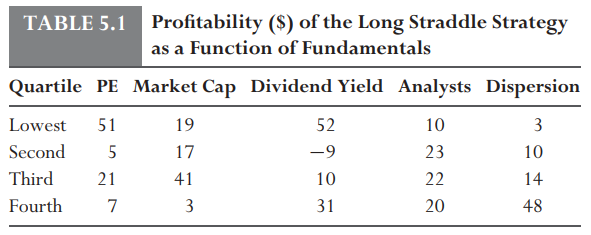
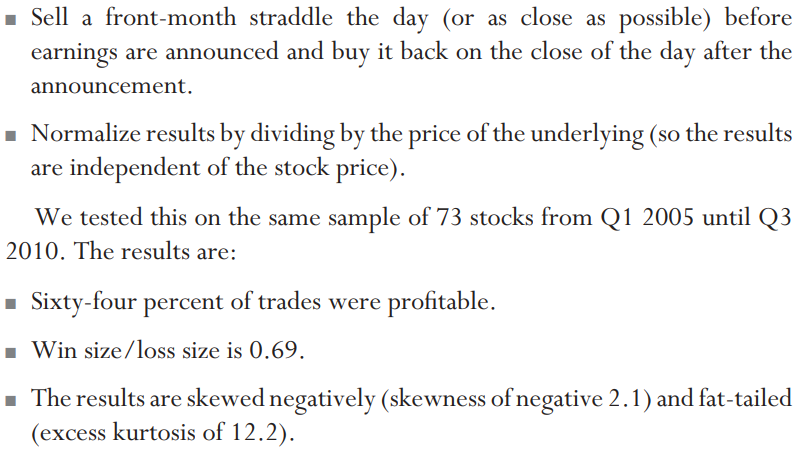
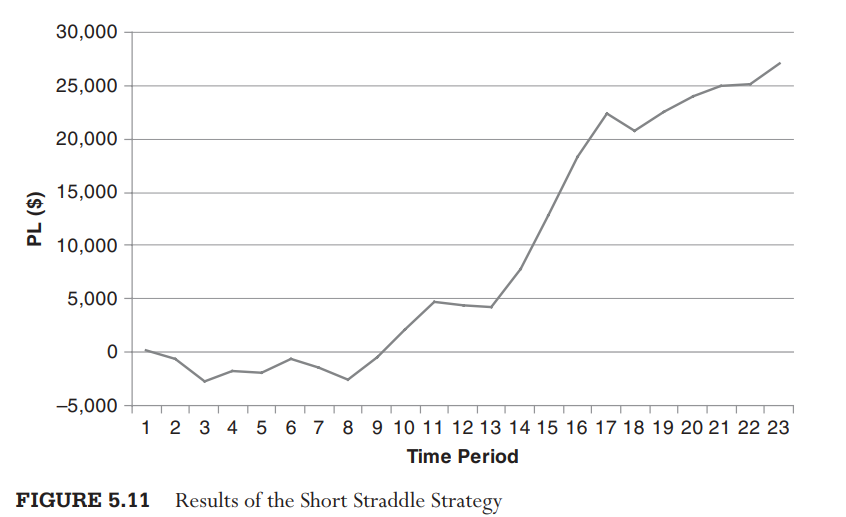